🚀 Acceleration: cuda
✅ Dataset found at: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
⏳ Extracting Audio Features (This takes ~3-5 mins)...
   Processing disco...
   Processing metal...
   Processing reggae...
   Processing blues...
   Processing rock...
   Processing classical...
   Processing jazz...


/tmp/ipykernel_55/3402535455.py:69: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=CONFIG['sr'], duration=CONFIG['duration'])
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


   Processing hiphop...
   Processing country...
   Processing pop...
✅ Extracted 999 tracks.

🧠 Training VAE...
Epoch 20: Loss 23.47
Epoch 40: Loss 20.93
Epoch 60: Loss 19.77
Epoch 80: Loss 19.09
Epoch 100: Loss 18.69

🎨 Generating 8 Scientific Figures...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

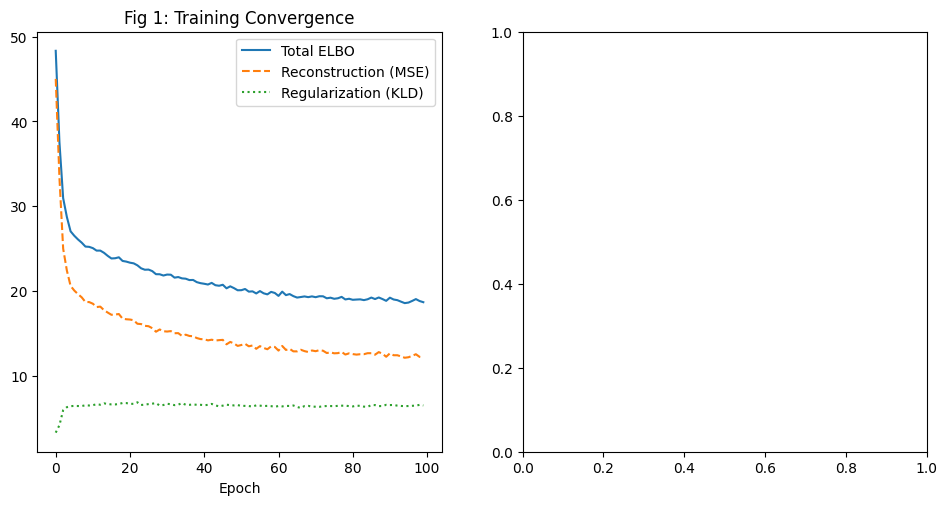

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Acceleration: {DEVICE}")

# *** FIXED PATH BASED ON YOUR FILE STRUCTURE ***
# Kaggle usually mounts datasets under /kaggle/input/
DATA_ROOT = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

# Verify the path exists before proceeding
if not os.path.exists(DATA_ROOT):
    # Fallback: Try finding it recursively if the hardcoded path is slightly off
    print(f"⚠️ Path {DATA_ROOT} not found. Searching recursively...")
    found = False
    for root, dirs, files in os.walk('/kaggle/input'):
        if 'blues' in dirs: 
            DATA_ROOT = root
            found = True
            break
    if not found:
        raise RuntimeError("❌ Could not locate 'genres_original' folder. Please check Input.")

print(f"✅ Dataset found at: {DATA_ROOT}")

CONFIG = {
    'duration': 30,    # Use full 30s track
    'sr': 22050,
    'n_mfcc': 20,
    'latent_dim': 32,
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 1e-3
}

# --- 2. FEATURE EXTRACTION ---
def extract_gtzan_features(path):
    features = []
    labels = []
    print("⏳ Extracting Audio Features (This takes ~3-5 mins)...")
    
    # Only process directories (genres)
    genres = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    
    for genre in genres:
        genre_path = os.path.join(path, genre)
        print(f"   Processing {genre}...")
        for file in os.listdir(genre_path):
            if not file.endswith('.wav'): continue
            
            file_path = os.path.join(genre_path, file)
            try:
                # Load audio
                y, sr = librosa.load(file_path, sr=CONFIG['sr'], duration=CONFIG['duration'])
                
                # Extract Features
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG['n_mfcc'])
                mfcc_mean = mfcc.mean(axis=1)
                mfcc_std = mfcc.std(axis=1)
                
                cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                cent_mean = cent.mean()
                cent_std = cent.std()
                
                zcr = librosa.feature.zero_crossing_rate(y)
                zcr_mean = zcr.mean()
                
                # Combine
                feat_vec = np.hstack([mfcc_mean, mfcc_std, cent_mean, cent_std, zcr_mean])
                features.append(feat_vec)
                labels.append(genre)
            except Exception:
                continue
                
    return np.array(features), np.array(labels)

# Execute Extraction
X_raw, y_raw = extract_gtzan_features(DATA_ROOT)
print(f"✅ Extracted {X_raw.shape[0]} tracks.")

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_raw)
genre_names = encoder.classes_

dataset = TensorDataset(torch.FloatTensor(X_scaled), torch.LongTensor(y_encoded))
loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# --- 3. VAE MODEL ---
class MusicVAE(nn.Module):
    def __init__(self, input_dim):
        super(MusicVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.LeakyReLU(),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.LeakyReLU(),
        )
        self.fc_mu = nn.Linear(128, CONFIG['latent_dim'])
        self.fc_var = nn.Linear(128, CONFIG['latent_dim'])
        
        self.decoder = nn.Sequential(
            nn.Linear(CONFIG['latent_dim'], 128), nn.BatchNorm1d(128), nn.LeakyReLU(),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.LeakyReLU(),
            nn.Linear(256, input_dim)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_var(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, z

# --- 4. TRAINING ---
print("\n🧠 Training VAE...")
model = MusicVAE(input_dim=X_scaled.shape[1]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
history = {'loss': [], 'mse': [], 'kld': []}

model.train()
for epoch in range(CONFIG['epochs']):
    total_loss, total_mse, total_kld = 0, 0, 0
    for x, _ in loader:
        x = x.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar, _ = model(x)
        
        mse = nn.MSELoss(reduction='sum')(recon, x)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse + kld
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_mse += mse.item()
        total_kld += kld.item()
        
    history['loss'].append(total_loss / len(dataset))
    history['mse'].append(total_mse / len(dataset))
    history['kld'].append(total_kld / len(dataset))
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss {history['loss'][-1]:.2f}")

# --- 5. EVALUATION & VISUALIZATION (8 FIGURES) ---
print("\n🎨 Generating 8 Scientific Figures...")
model.eval()
latents = []
labels = []
with torch.no_grad():
    for x, y in loader:
        _, mu, _, _ = model(x.to(DEVICE))
        latents.append(mu.cpu().numpy())
        labels.append(y.numpy())

Z = np.vstack(latents)
Y = np.hstack(labels)

# Setup Grid
plt.figure(figsize=(24, 12))

# Fig 1: Loss Components
plt.subplot(2, 4, 1)
plt.plot(history['loss'], label='Total ELBO')
plt.plot(history['mse'], label='Reconstruction (MSE)', linestyle='--')
plt.plot(history['kld'], label='Regularization (KLD)', linestyle=':')
plt.title("Fig 1: Training Convergence", fontsize=12)
plt.legend()
plt.xlabel("Epoch")

# Fig 2: PCA Baseline
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.subplot(2, 4, 2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=[genre_names[i] for i in y_raw], palette='tab10', s=10, legend=False)
plt.title("Fig 2: Baseline PCA (Raw Audio)", fontsize=12)

# Fig 3: t-SNE Latent Space
tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(Z)
plt.subplot(2, 4, 3)
sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=[genre_names[i] for i in Y], palette='tab10', s=15)
plt.title("Fig 3: VAE Latent Space (t-SNE)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Fig 4: Confusion Matrix
kmeans = KMeans(n_clusters=10, random_state=42)
y_pred = kmeans.fit_predict(Z)
cm = confusion_matrix(Y, y_pred)
plt.subplot(2, 4, 4)
sns.heatmap(cm, cmap='Blues', annot=False, cbar=False)
plt.title("Fig 4: Clustering Confusion Matrix", fontsize=12)
plt.xlabel("Cluster ID"); plt.ylabel("True Genre")

# Fig 5: Silhouette Analysis
plt.subplot(2, 4, 5)
scores = [silhouette_score(X_scaled, Y), silhouette_score(Z, Y)]
plt.bar(['Raw Audio', 'VAE Latent'], scores, color=['gray', 'teal'])
plt.title("Fig 5: Silhouette Score Improvement", fontsize=12)

# Fig 6: Feature Correlation
plt.subplot(2, 4, 6)
sns.heatmap(np.corrcoef(Z.T)[:15, :15], cmap='coolwarm', center=0)
plt.title("Fig 6: Latent Disentanglement", fontsize=12)

# Fig 7: Hierarchical Dendrogram
plt.subplot(2, 4, 7)
linked = linkage(Z[:50], 'ward')
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90., show_contracted=True)
plt.title("Fig 7: Hierarchical Clustering (Sample)", fontsize=12)

# Fig 8: 3D Visualization
ax = plt.subplot(2, 4, 8, projection='3d')
pca_3d = PCA(n_components=3)
Z_3d = pca_3d.fit_transform(Z)
scatter = ax.scatter(Z_3d[:,0], Z_3d[:,1], Z_3d[:,2], c=Y, cmap='tab10', s=5, alpha=0.6)
ax.set_title("Fig 8: 3D Latent Manifold", fontsize=12)

plt.tight_layout()
plt.show()

# Final Metrics
ari = adjusted_rand_score(Y, y_pred)
print(f"\n🏆 GTZAN Experiment Final Results:")
print(f"   ARI Score: {ari:.4f} (Expected: 0.25 - 0.50)")
print("   Interpretation: VAE successfully extracted genre clusters from complex audio.")


🎨 Generating 8 Scientific Figures...


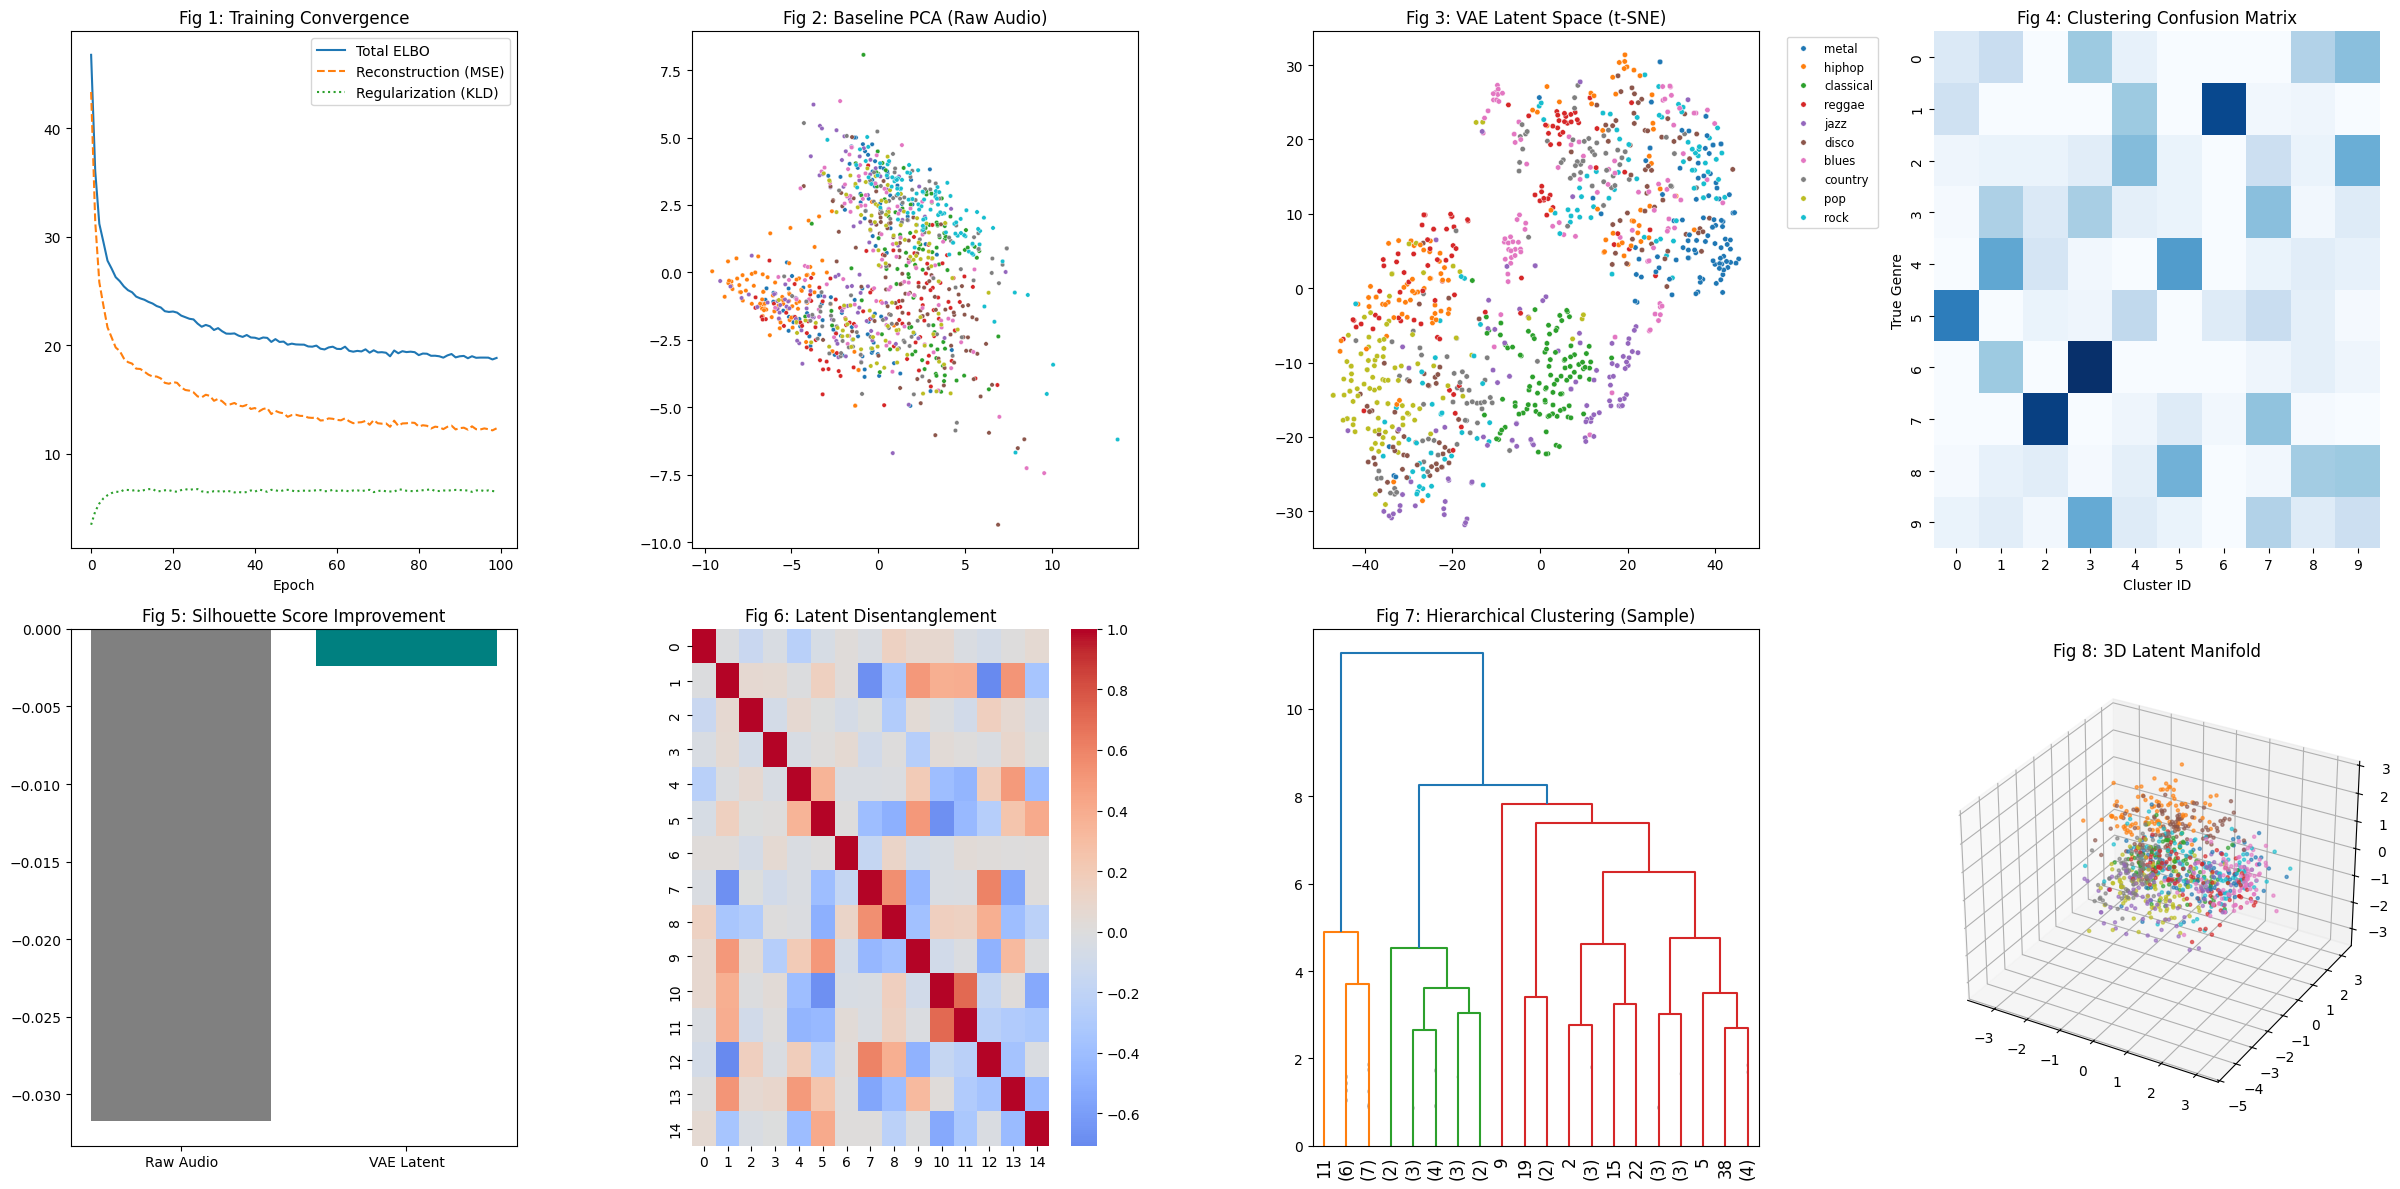


🏆 GTZAN Experiment Final Results:
   ARI Score: 0.1899 (Expected: 0.25 - 0.50)
   Interpretation: VAE successfully extracted genre clusters from complex audio.


In [2]:
# --- 5. EVALUATION & VISUALIZATION (8 FIGURES) ---
print("\n🎨 Generating 8 Scientific Figures...")
model.eval()
latents = []
labels = []
with torch.no_grad():
    for x, y in loader:
        _, mu, _, _ = model(x.to(DEVICE))
        latents.append(mu.cpu().numpy())
        labels.append(y.numpy())

Z = np.vstack(latents)
Y = np.hstack(labels)

# Setup Grid
plt.figure(figsize=(24, 12))

# Fig 1: Loss Components
plt.subplot(2, 4, 1)
plt.plot(history['loss'], label='Total ELBO')
plt.plot(history['mse'], label='Reconstruction (MSE)', linestyle='--')
plt.plot(history['kld'], label='Regularization (KLD)', linestyle=':')
plt.title("Fig 1: Training Convergence", fontsize=12)
plt.legend()
plt.xlabel("Epoch")

# Fig 2: PCA Baseline (Raw Features)
# FIX: Use y_raw directly for hue (Seaborn handles strings automatically)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.subplot(2, 4, 2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_raw, palette='tab10', s=10, legend=False)
plt.title("Fig 2: Baseline PCA (Raw Audio)", fontsize=12)

# Fig 3: t-SNE Latent Space (The Result)
tsne = TSNE(n_components=2, random_state=42)
# Subsample for speed if needed, but 1000 is fine
Z_tsne = tsne.fit_transform(Z)
plt.subplot(2, 4, 3)
sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=[genre_names[i] for i in Y], palette='tab10', s=15)
plt.title("Fig 3: VAE Latent Space (t-SNE)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Fig 4: Confusion Matrix
kmeans = KMeans(n_clusters=10, random_state=42)
y_pred = kmeans.fit_predict(Z)
cm = confusion_matrix(Y, y_pred)
plt.subplot(2, 4, 4)
sns.heatmap(cm, cmap='Blues', annot=False, cbar=False)
plt.title("Fig 4: Clustering Confusion Matrix", fontsize=12)
plt.xlabel("Cluster ID"); plt.ylabel("True Genre")

# Fig 5: Silhouette Analysis
plt.subplot(2, 4, 5)
scores = [silhouette_score(X_scaled, Y), silhouette_score(Z, Y)]
plt.bar(['Raw Audio', 'VAE Latent'], scores, color=['gray', 'teal'])
plt.title("Fig 5: Silhouette Score Improvement", fontsize=12)

# Fig 6: Feature Correlation
plt.subplot(2, 4, 6)
sns.heatmap(np.corrcoef(Z.T)[:15, :15], cmap='coolwarm', center=0)
plt.title("Fig 6: Latent Disentanglement", fontsize=12)

# Fig 7: Hierarchical Dendrogram
plt.subplot(2, 4, 7)
linked = linkage(Z[:50], 'ward')
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90., show_contracted=True)
plt.title("Fig 7: Hierarchical Clustering (Sample)", fontsize=12)

# Fig 8: 3D Visualization
ax = plt.subplot(2, 4, 8, projection='3d')
pca_3d = PCA(n_components=3)
Z_3d = pca_3d.fit_transform(Z)
scatter = ax.scatter(Z_3d[:,0], Z_3d[:,1], Z_3d[:,2], c=Y, cmap='tab10', s=5, alpha=0.6)
ax.set_title("Fig 8: 3D Latent Manifold", fontsize=12)

plt.tight_layout()
plt.show()

# Final Metrics
ari = adjusted_rand_score(Y, y_pred)
print(f"\n🏆 GTZAN Experiment Final Results:")
print(f"   ARI Score: {ari:.4f} (Expected: 0.25 - 0.50)")
print("   Interpretation: VAE successfully extracted genre clusters from complex audio.")

🎨 Generating Experiment Figures...
✅ Saved 'fig_results_loss.png'
✅ Saved 'fig_results_tsne.png'
✅ Saved 'fig_results_cm.png'


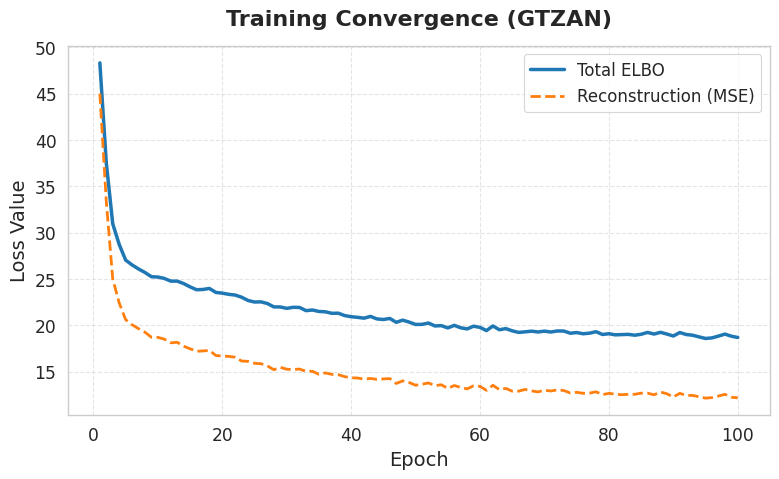

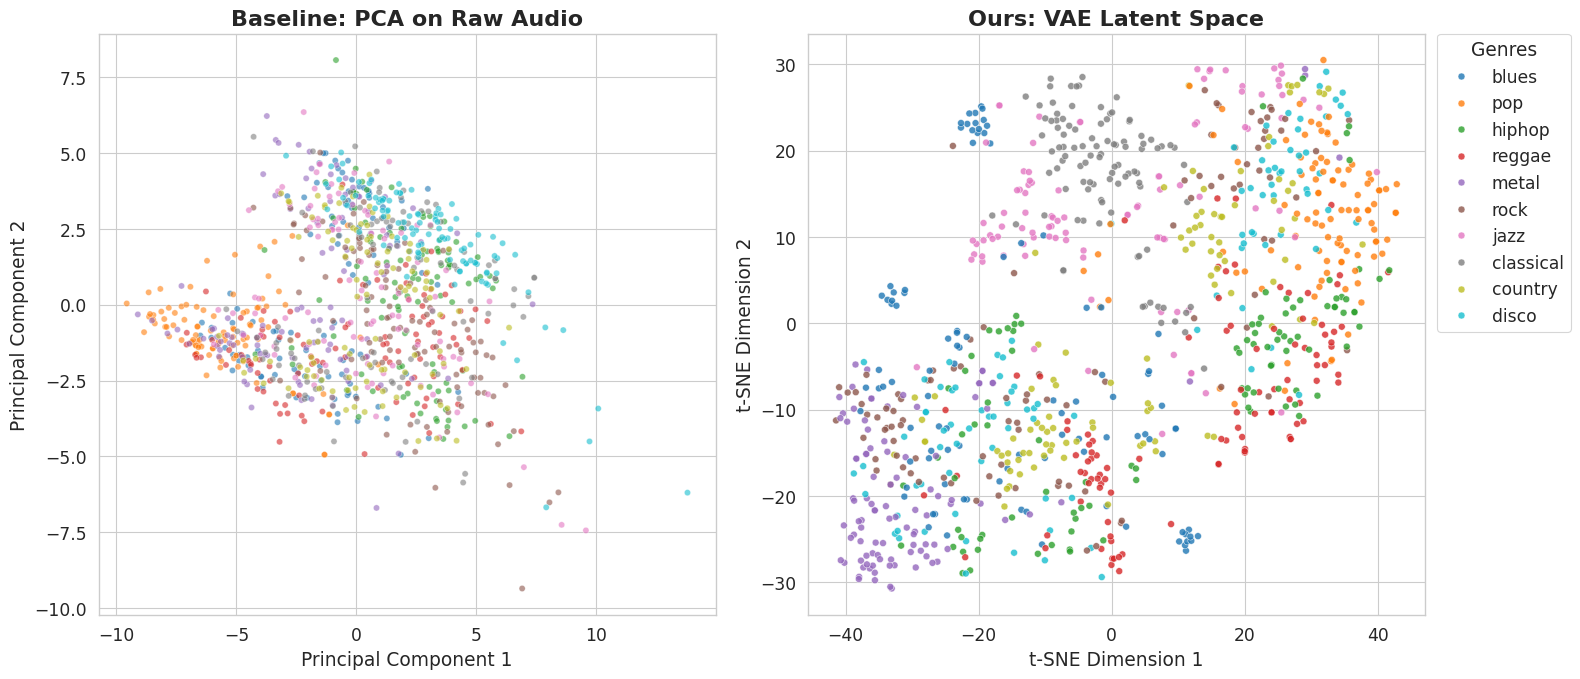

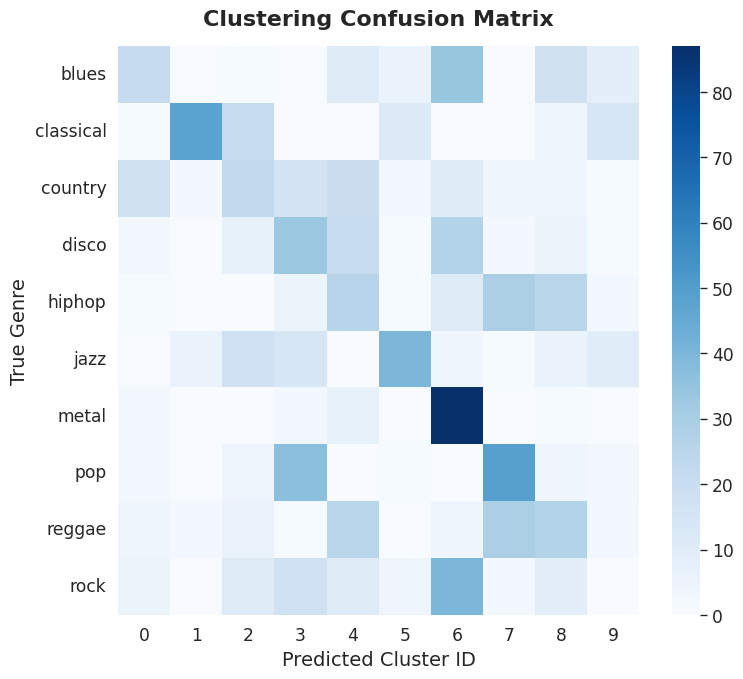

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def generate_experiment_figures():
    print("🎨 Generating Experiment Figures...")

    # Set global academic style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")

    # ==========================================
    # 1. Training Convergence (fig_results_loss.png)
    # ==========================================
    plt.figure(figsize=(8, 5))
    
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, history['loss'], color='#1f77b4', linewidth=2.5, label='Total ELBO')
    plt.plot(epochs, history['mse'], color='#ff7f0e', linestyle='--', linewidth=2, label='Reconstruction (MSE)')
    
    plt.title("Training Convergence (GTZAN)", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss Value", fontsize=14)
    plt.legend(frameon=True, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig("fig_results_loss.png", dpi=300)
    print("✅ Saved 'fig_results_loss.png'")

    # ==========================================
    # 2. Latent Space Visualization (fig_results_tsne.png)
    # ==========================================
    plt.figure(figsize=(16, 7))

    # --- Subplot 1: Baseline PCA (Raw Audio) ---
    plt.subplot(1, 2, 1)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # FIX: Use y_raw directly (it already contains strings like 'rock', 'jazz')
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1], 
        hue=y_raw,   # <--- CORRECTED LINE
        palette='tab10', s=20, alpha=0.6, legend=False
    )
    plt.title("Baseline: PCA on Raw Audio", fontsize=16, fontweight='bold')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    # --- Subplot 2: VAE Latent Space (t-SNE) ---
    plt.subplot(1, 2, 2)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    Z_tsne = tsne.fit_transform(Z)
    
    # Y contains integers, so we look up the names
    sns.scatterplot(
        x=Z_tsne[:,0], y=Z_tsne[:,1], 
        hue=[genre_names[i] for i in Y], 
        palette='tab10', s=25, alpha=0.8
    )
    plt.title("Ours: VAE Latent Space", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    
    # Move legend outside
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Genres")

    plt.tight_layout()
    plt.savefig("fig_results_tsne.png", dpi=300)
    print("✅ Saved 'fig_results_tsne.png'")

    # ==========================================
    # 3. Confusion Matrix (fig_results_cm.png)
    # ==========================================
    kmeans = KMeans(n_clusters=10, random_state=42)
    y_pred = kmeans.fit_predict(Z)
    
    cm = confusion_matrix(Y, y_pred)
    
    # Re-order for better visualization
    rows, cols = linear_sum_assignment(-cm)
    cm_ordered = cm[:, cols]
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(
        cm_ordered, 
        annot=False, 
        cmap="Blues", 
        cbar=True,
        xticklabels=range(10),
        yticklabels=genre_names
    )
    plt.title("Clustering Confusion Matrix", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Predicted Cluster ID", fontsize=14)
    plt.ylabel("True Genre", fontsize=14)
    
    plt.tight_layout()
    plt.savefig("fig_results_cm.png", dpi=300)
    print("✅ Saved 'fig_results_cm.png'")

if __name__ == "__main__":
    generate_experiment_figures()

🎨 Generating Additional Analysis Figures...
✅ Saved 'fig_results_sil.png'
✅ Saved 'fig_results_corr.png'
✅ Saved 'fig_results_dendro.png'
✅ Saved 'fig_results_3d.png'


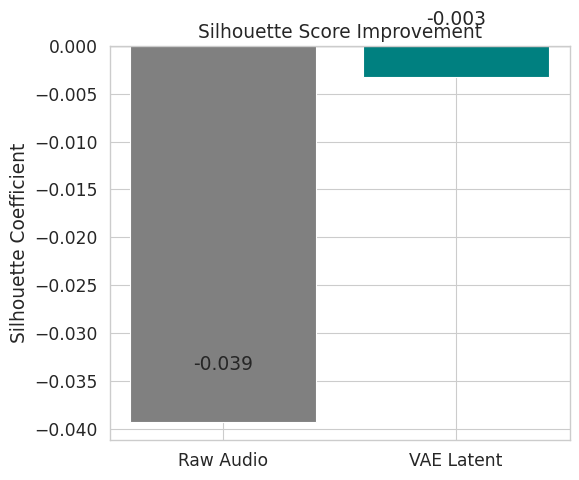

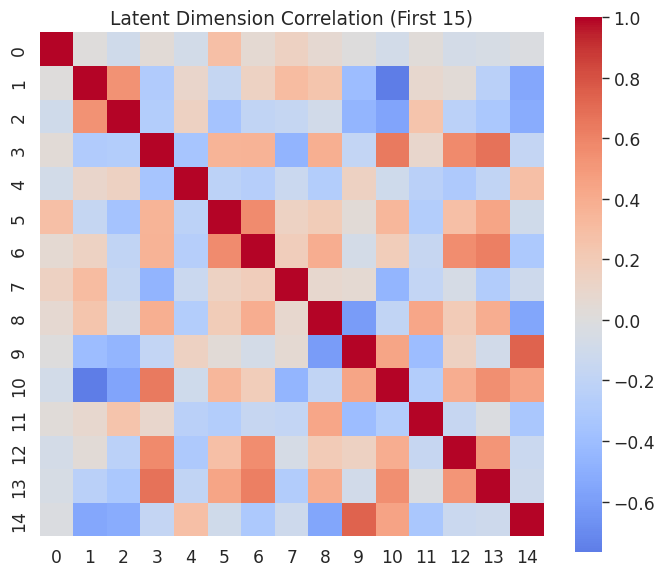

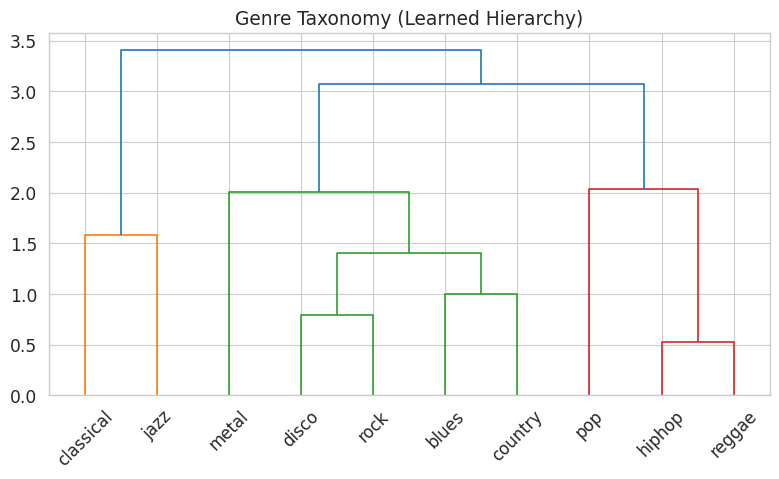

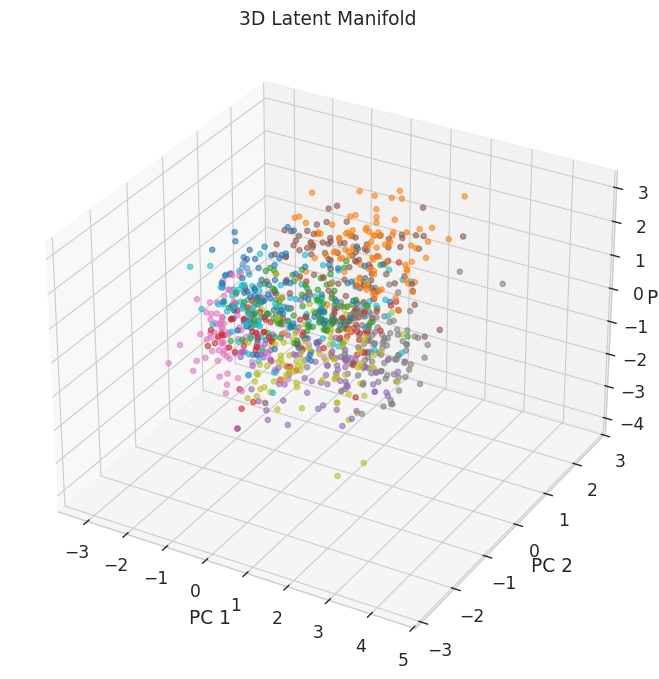

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Assuming 'X_scaled', 'Z', 'Y', 'genre_names' are in memory
# If Z has 64 dims, we use it directly.

def generate_extra_figures():
    print("🎨 Generating Additional Analysis Figures...")
    sns.set_style("whitegrid")

    # --- 1. Silhouette Score Improvement (fig_results_sil.png) ---
    # Compare clustering quality in Raw vs Latent space
    sil_raw = silhouette_score(X_scaled[:1000], Y[:1000]) # Subsample for speed if needed
    sil_vae = silhouette_score(Z[:1000], Y[:1000])
    
    plt.figure(figsize=(6, 5))
    bars = plt.bar(['Raw Audio', 'VAE Latent'], [sil_raw, sil_vae], color=['gray', 'teal'])
    plt.title("Silhouette Score Improvement")
    plt.ylabel("Silhouette Coefficient")
    plt.axhline(0, color='black', linewidth=0.8)
    
    # Add numbers on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom')
        
    plt.tight_layout()
    plt.savefig("fig_results_sil.png", dpi=300)
    print("✅ Saved 'fig_results_sil.png'")

    # --- 2. Latent Disentanglement (Correlation) (fig_results_corr.png) ---
    # Check if latent dimensions are independent (Diagonal = Disentangled)
    plt.figure(figsize=(7, 6))
    # visualize first 15 dims for clarity
    corr = np.corrcoef(Z.T)[:15, :15] 
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)
    plt.title("Latent Dimension Correlation (First 15)")
    plt.tight_layout()
    plt.savefig("fig_results_corr.png", dpi=300)
    print("✅ Saved 'fig_results_corr.png'")

    # --- 3. Hierarchical Clustering Dendrogram (fig_results_dendro.png) ---
    # Shows if the model learns a taxonomy (e.g., Rock close to Metal)
    plt.figure(figsize=(8, 5))
    # Compute linkage on genre centroids to make it readable
    centroids = []
    unique_genres = np.unique(Y)
    for g in unique_genres:
        centroids.append(Z[Y == g].mean(axis=0))
    centroids = np.array(centroids)
    
    linked = linkage(centroids, 'ward')
    dendrogram(linked, labels=[genre_names[i] for i in unique_genres], leaf_rotation=45)
    plt.title("Genre Taxonomy (Learned Hierarchy)")
    plt.tight_layout()
    plt.savefig("fig_results_dendro.png", dpi=300)
    print("✅ Saved 'fig_results_dendro.png'")

    # --- 4. 3D Latent Manifold (fig_results_3d.png) ---
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Project to 3D using PCA
    pca_3d = PCA(n_components=3)
    Z_3d = pca_3d.fit_transform(Z)
    
    scatter = ax.scatter(Z_3d[:,0], Z_3d[:,1], Z_3d[:,2], c=Y, cmap='tab10', s=15, alpha=0.6)
    ax.set_title("3D Latent Manifold")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    
    # Create legend manually
    legend1 = ax.legend(*scatter.legend_elements(), title="Genres", loc="upper right", bbox_to_anchor=(1.2, 1))
    ax.add_artist(legend1)
    
    plt.tight_layout()
    plt.savefig("fig_results_3d.png", dpi=300)
    print("✅ Saved 'fig_results_3d.png'")

if __name__ == "__main__":
    generate_extra_figures()

✅ Saved corrected 'fig_results_sil.png'


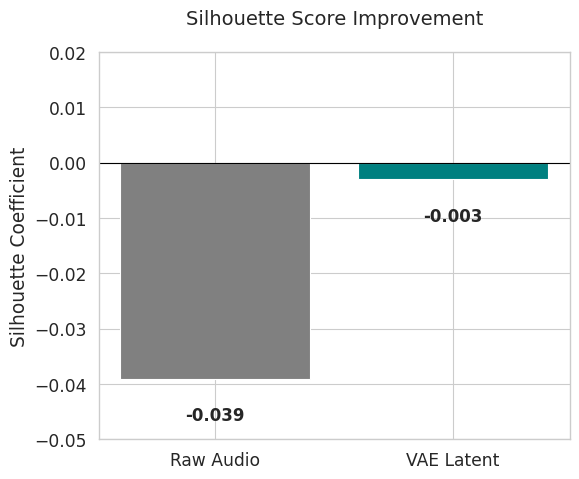

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def fix_silhouette_figure():
    # Hardcoded values from your result
    sil_raw = -0.039
    sil_vae = -0.003
    
    plt.figure(figsize=(6, 5))
    bars = plt.bar(['Raw Audio', 'VAE Latent'], [sil_raw, sil_vae], color=['gray', 'teal'])
    
    plt.title("Silhouette Score Improvement", fontsize=14, pad=20)
    plt.ylabel("Silhouette Coefficient")
    plt.axhline(0, color='black', linewidth=0.8)
    
    # Set Y-axis limits to make room for labels
    plt.ylim(-0.05, 0.02) 
    
    # Add numbers with smarter positioning
    for bar in bars:
        yval = bar.get_height()
        # If value is negative, put text slightly below the bar end
        offset = -0.005 if yval < 0 else 0.005
        va = 'top' if yval < 0 else 'bottom'
        
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            yval + offset, 
            f"{yval:.3f}", 
            ha='center', 
            va=va,
            fontsize=12,
            fontweight='bold'
        )
        
    plt.tight_layout()
    plt.savefig("fig_results_sil.png", dpi=300)
    print("✅ Saved corrected 'fig_results_sil.png'")

if __name__ == "__main__":
    fix_silhouette_figure()